![DLI Logo](../assets/DLI_Header.png)

# Introduction

In this module, we'll continue exploring **extraction** and apply it to more interesting models and data. 

## Learning Objectives:
1. Execute the Proof-Pudding attack ([CVE-2019-20634](https://nvd.nist.gov/vuln/detail/CVE-2019-20634)).
2. Extract a model useful for cybersecurity.

# Model Extraction
Okay - let's take a break from the heavy math for a minute. Give your brain some nice charts to look at :) 

In our opinion model extraction is _the_ most fundamental attack technique you could possibly learn. It is so relatively simple and effective. It provides the most options as it relates to using other attacks, and it does not require anything of a target other than the ability to submit inputs and collect outputs. Which you then use to train your own model. Attacks on ML in the wild are implicitly imprecise, and no amount of math can generate perfect information from nothing -- you can only _approximate_. This is what this attack does, we use our awesome modeling skills to model the target model. Perhaps unlike Evasion or other algorithmic attacks, where your advantage might come from clever mathematical tricks. In Extraction, your edge as an attacker lies in your ability to reduce a search space by engineering your datasets and models in such a way that you can adequately drive toward your desired outcome. 

- Do you want to know what the model thinks about cats? Send it pictures of all kinds of different cats. 
- Do you want to know what the model thinks about malware? Send it all different kinds of malware.
- Do you want to know what the model thinks about X? Send it ~X.

There are some higher level strategies about what from your dataset you send first. For example, you could send a starting input, then measure the distance between that sample and everything else and choose, let's say, the next sample that is _furthest_ away. This would ensure you're not sending similar samples and only learning about those from the model. This is anecdotal, but it seems that a more diverse dataset generally leads a more diverse set of observations to learn from. But when running an extraction attack you should consider the types of outputs you can receive (or the heuristic measures you could put in place),

- The worst case scenario is that the target returns a binary value like `0` or `1` (which could mean execution or not).
- The best case is scenario is the target product returns a continuous value, a value between `0` and `1` (or probabilities)

Intuitively, a continuous value gives you more information about what the target model thinks of each input. Each minor modification returns a change in the output, and when you train a copy-cat model, it will (hopefully) be more accurate as a result. As opposed to a binary value, where even large changes in the input would not necessarily generate a different output. However, for any given model in the wild, you can't be as sure about the model you're attacking. For example, you won't know how the data is processed, what base model is being used, or even necessarily what the target even does with the output. Sometimes, you don't even know what the input is and you're just in a "make the number go up or down" game! (Think about this for a second - if you only had numbers in and numbers out, could you train a model without any contextual information? Yes!) 

In this lab we're going to explore the mechanics and data behind two extraction attacks - Proof-Pudding and extracting AMSI (and later we'll do an LLM). We'll show you how even before you do _any_ modeling you can infer decision boundaries, or if you want to use other attack types -- you can use these techniques to help you decide which features you might want to perturb or focus on. We'll start by showing you how to analyze a dataset, then you will be let loose on 150,000 AMSI labeled PowerShell scripts. 

Okay, let's begin.


# Imports
We'll start by importing everything we'll need up top. You can perhaps start to see all the different tools and utilities that make up an ML development pipeline - remember when we did neural networks? That lab had only 2 imports!

:::{note}
Now would be a good time to shut down any notebook kernels you are not currently using to free up some RAM. You can do so by clicking on the Circle with a square in it, on the left side of the JupyterLab Window.

In [1]:
# DO NOT CHANGE

import pandas as pd
import base64
import numpy as np
import matplotlib.pyplot as plt
import torch

from datasets import Dataset, DatasetDict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from transformers import AutoModelForSequenceClassification, AutoTokenizer


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

C:\Users\Usuario\Anaconda3\envs\llama\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


# Exploratory Data Analysis
While building models is cool, collecting and analyzing data often enables "better science". We'll start with `CVE-2019-20634` data. In this case, the researchers noticed mail headers were revealing model scores. They devised a way to extract `n` number of scores by sending emails to a non-existent address. This would cause the clients mail server to bounce the email, but only after it had been scored. To get around being marked as spam by the service provider used to send emails (because of all the bounced emails), they manually set the return path header to a separate receiving address. This ensured the sender wouldn't see the bounce rate. 

But what can you do with this header information? How can you generate a sufficiently large and diverse set of emails to collect an interesting dataset? In this case, they used the [Enron Dataset](https://www.cs.cmu.edu/~enron/). The dataset was chosen because it was _representative_ of the task at hand - emails. Could you send random text? Sure. But ideally you want to know about the task the model was trained on (or about how the model performs on a task _you_ care about). Let's go do some analysis. 

In [2]:
# DO NOT CHANGE

# Read in a CSV file containing text data
df = pd.read_csv("data/texts.csv")

# Decode the subject from base64
df["subject"] = (
    # encode the strings to bytes
    df["subject"].str.encode("utf-8", "strict")
    # decode each byte string
    .apply(base64.b64decode)
    # decode the bytes back to UTF-8
    .str.decode("utf-8")
)

# Decode the content from base64 encoding (same as above)
df["content"] = (
    df["content"].str.encode("utf-8", "strict")
    .apply(base64.b64decode)
    .str.decode("utf-8")
)

df.head()

,subject,content,rule,policy,score,bulkscore,malwarescore,priorityscore,spamscore,phishscore,...,lowpriorityscore,suspectscore,adultscore,clxscore,classifier,adjust,reason,scancount,engine,definitions
0,Enron,\nMr. Lay:\nI am a former Enron employee. I u...,nodigest_notspam,nodigest,0,2,0,0,0,0,...,2,3,0,495,spam,0,mlx,1,8.12.0-1906280000,main-1908280184
1,Homestead Expansion - Update,The Homestead precedent agreements are going o...,nodigest_notspam,nodigest,0,0,0,0,0,0,...,0,3,0,465,spam,0,mlx,1,8.12.0-1906280000,main-1908280183
2,XMS Upgrade Transition Plan - All XMS Users Pl...,\r\n \t\tConcur Expense (XMS) Upgrade!\r\n\...,nodigest_notspam,nodigest,0,0,0,0,0,0,...,0,3,0,515,spam,0,mlx,1,8.12.0-1906280000,main-1908280182
3,St. Dominics,Oops. Can you forward my response to Margaret...,nodigest_notspam,nodigest,0,0,0,0,0,0,...,0,3,0,515,spam,0,mlx,1,8.12.0-1906280000,main-1908280184
4,VAR 12/28/01,As an aside?.\n\tNormal\t\t\tHistorical Vol\nC...,nodigest_notspam,nodigest,0,0,0,0,0,0,...,0,3,0,432,spam,0,mlx,1,8.12.0-1906280000,main-1908280184


Here the researcher controlled `subject` and `content` and collected the rest of the data from the headers. You should also notice that we're using `pandas` which is a great library for handling tabular data that can fit in RAM. It has many useful and vectorized functions for efficient data analysis and processing, and it looks good in Jupyter!

You can get a quick overview of your data using `describe`


In [4]:
# DO NOT CHANGE

df.describe(include="all")

,subject,content,rule,policy,score,bulkscore,malwarescore,priorityscore,spamscore,phishscore,...,lowpriorityscore,suspectscore,adultscore,clxscore,classifier,adjust,reason,scancount,engine,definitions
count,9898,9898,9898,9898,9898.000000,9898.000000,9898.0,9898.000000,9898.000000,9898.0,...,9898.000000,9898.000000,9898.000000,9898.000000,9898,9898.0,9898,9898.000000,9898,9898
unique,7089,8675,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,NaN,1,NaN,1,7
top,No Subject,"\nAs you know, Enron has signed a merger agree...",nodigest_notspam,nodigest,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,spam,NaN,mlx,NaN,8.12.0-1906280000,main-1908280184
freq,330,27,9898,9898,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,9898,NaN,9898,NaN,9898,3682
mean,NaN,NaN,NaN,NaN,0.037078,2.214488,0.0,14.796828,0.037078,0.0,...,2.214488,3.705294,0.084462,487.993029,NaN,0.0,NaN,1.000606,NaN,NaN
std,NaN,NaN,NaN,NaN,1.050863,13.954275,0.0,69.776046,1.050863,0.0,...,13.954275,3.883852,1.291557,47.859147,NaN,0.0,NaN,0.024615,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,308.000000,NaN,0.0,NaN,1.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,3.000000,0.000000,456.000000,NaN,0.0,NaN,1.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,3.000000,0.000000,490.000000,NaN,0.0,NaN,1.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,3.000000,0.000000,515.000000,NaN,0.0,NaN,1.000000,NaN,NaN


Immediately we see that some of the columns are not very helpful - let's delete those. In this case, we're defining "not helpful" as "only having one unique value for every data point". Think back to the linear model's module. If every data point has the same value for a given feature, does that feature help a machine learning model learn anything? No! 

Here we use `drop` to remove columns, and we do it `inplace` which prevents us from creating a new dataframe in memory. 

In [3]:
# DO NOT CHANGE

df.drop(columns=[x for x in df.columns if len(df[x].unique()) == 1], inplace=True)

You will start to get a feel for the process and you analyze more and more datasets, but a lot of EDA (and model building) is cleaning data, and figuring out what's worth your time to analyze.

Once you start transforming data, try to write **idempotent** code. That's a fancy word that means "no matter how many times you execute this, you'll always get the same result." For example, we could have written the drop with something like `df.drop(columns=["phishscore", "imposterscore"])`, but after you've executed that code once any subsequent execution would result in an error (because those columns wouldn't exist anymore). Instead, by writing functional and idempotent code, we can execute the above cell any number of times while maintaining correct output. Idempotent data transformations will save you a lot of time and headaches.

In [6]:
# DO NOT CHANGE

df.describe(include="all")

,subject,content,score,bulkscore,priorityscore,spamscore,mlxscore,mlxlogscore,lowpriorityscore,suspectscore,adultscore,clxscore,scancount,definitions
count,9898,9898,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000,9898
unique,7089,8675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
top,No Subject,"\nAs you know, Enron has signed a merger agree...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,main-1908280184
freq,330,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3682
mean,NaN,NaN,0.037078,2.214488,14.796828,0.037078,0.037078,855.018287,2.214488,3.705294,0.084462,487.993029,1.000606,NaN
std,NaN,NaN,1.050863,13.954275,69.776046,1.050863,1.050863,153.995756,13.954275,3.883852,1.291557,47.859147,0.024615,NaN
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,308.000000,1.000000,NaN
25%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,746.000000,0.000000,3.000000,0.000000,456.000000,1.000000,NaN
50%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,891.000000,0.000000,3.000000,0.000000,490.000000,1.000000,NaN
75%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,999.000000,0.000000,3.000000,0.000000,515.000000,1.000000,NaN


This looks great - but what is a `NaN`? NaNs are a special value that indicate an undefined or unrepresentable value. `NaN` could be the result of a parsing error or be used to represent invalid operations like `0/0`, `∞ - ∞`. Libraries _usually_ provide mechanisms to gracefully handle potential NaNs in code instead of outright crashing.

:::{exercise}

1. Take a moment or two to simply look through the table above. Create a list of column names that you think might be interesting to use. You can use this list to select those columns from the dataframe later. 

:::

In [7]:
df.columns

Index(['subject', 'content', 'score', 'bulkscore', 'priorityscore',
       'spamscore', 'mlxscore', 'mlxlogscore', 'lowpriorityscore',
       'suspectscore', 'adultscore', 'clxscore', 'scancount', 'definitions'],
      dtype='object')

In [4]:
# Your code here

interesting = ["score", "subject", "content"] # add more columns
df[interesting].head()

,score,subject,content
0,0,Enron,\nMr. Lay:\nI am a former Enron employee. I u...
1,0,Homestead Expansion - Update,The Homestead precedent agreements are going o...
2,0,XMS Upgrade Transition Plan - All XMS Users Pl...,\r\n \t\tConcur Expense (XMS) Upgrade!\r\n\...
3,0,St. Dominics,Oops. Can you forward my response to Margaret...
4,0,VAR 12/28/01,As an aside?.\n\tNormal\t\t\tHistorical Vol\nC...


:::{dropdown} Solution
So long as you are exploring the data, your solution is correct, if your exploration doesn't yield anything interesting, try looking at different data, or at the data in a different way.

## Inferring Decision Boundaries
Ultimately, phishing classification is about drawing boundaries between classes - in this case spam or not spam. In an earlier lab we were able to plot the boundaries between each of the classes (remember `XORNet`?). Here we're researching how easy it may be to identify those boundaries in the `mlx` feature.

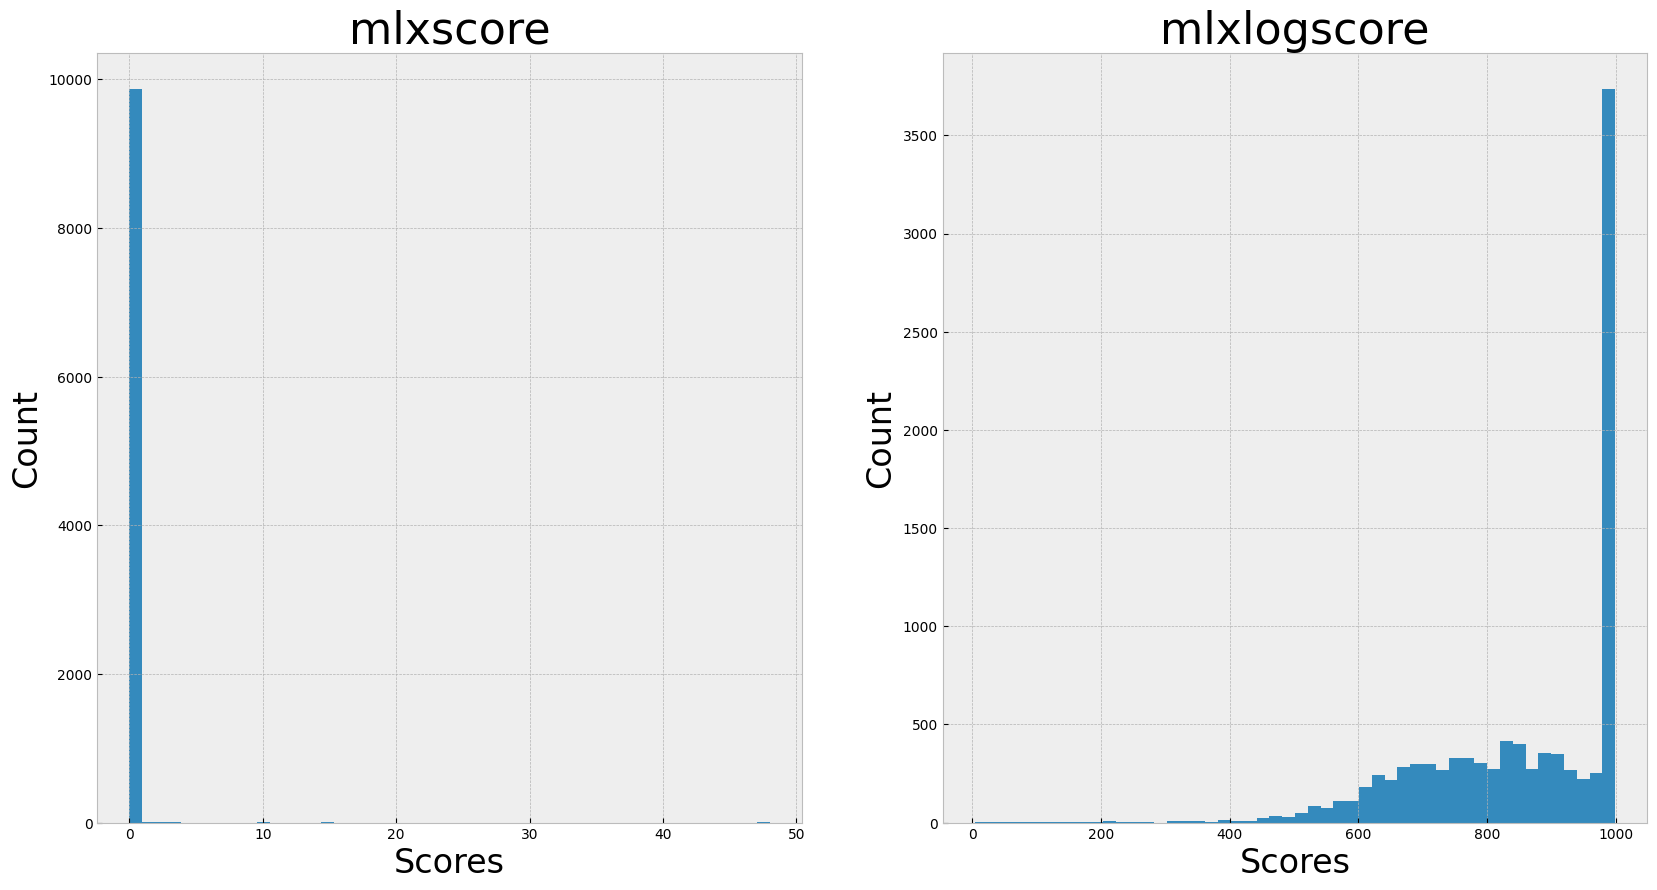

In [9]:
# DO NOT CHANGE

with plt.style.context("bmh"):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].hist(x=df["mlxscore"], bins=50)
    ax[0].set_title("mlxscore", fontdict={"fontsize": 32})
    ax[0].set_xlabel("Scores", fontdict={"fontsize": 24})
    ax[0].set_ylabel("Count", fontdict={"fontsize": 24})
    ax[1].hist(x=df["mlxlogscore"], bins=50)
    ax[1].set_title("mlxlogscore", fontdict={"fontsize": 32})
    ax[1].set_xlabel("Scores", fontdict={"fontsize": 24})
    ax[1].set_ylabel("Count", fontdict={"fontsize": 24})
plt.show()

Note that the `reason` column only ever listed `mlx`. Additionally, open source research will reveal that `mlx` is the designation for a machine learning product. That could be `mlxscore` or `mlxlogscore`. Do you have an intuition for what the `log()` function does to data `mlxscore`?

Logarithms invert exponential relationships and allow conversion between multiplication/division and addition/subtraction. This makes certain mathematical and scientific problems easier to analyze. Just like you might use `strings` to collect some human readable content to gain an intuition for what a binary is doing, understanding some math/data science lingo might help you understand features!

Even though it's easy to jump to using `mlxlogscore` as the primary score to focus on (because we're attacking ML, right?), what other scores or features might be useful to look at? Data visualization is a great technique for building intuition and exploring new datasets. Can you think of any data visualization technique that might tell you more than the histogram that we've been using? Try it out.


:::{exercise}

Create some additional charts of the scores you think would be interesting to look at.

```python
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,2, figsize=(20,10))
    ax[0].hist(x=df["mlxscore"], bins=50)
    ax[0].set_title("mlxscore", fontdict={'fontsize': 32})
    ax[0].set_xlabel("Scores", fontdict={'fontsize': 24})
    ax[0].set_ylabel("Count", fontdict={'fontsize': 24})
    ax[1].hist(x=df["mlxlogscore"], bins=50)
    ax[1].set_title("mlxlogscore", fontdict={'fontsize': 32})
    ax[1].set_xlabel("Scores", fontdict={'fontsize': 24})
    ax[1].set_ylabel("Count", fontdict={'fontsize': 24})
plt.show()
```

If you get stuck, check out the [answer key](answers-2_extraction.ipynb) for some ideas.
:::

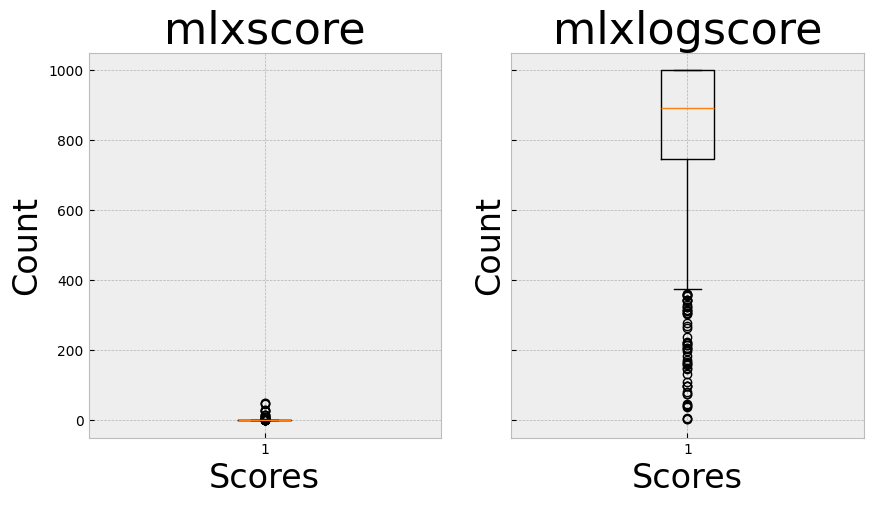

In [27]:
# your code here
with plt.style.context('bmh'):
    fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
    ax[0].boxplot(x=df["mlxscore"])
    ax[0].set_title("mlxscore", fontdict={'fontsize': 32})
    ax[0].set_xlabel("Scores", fontdict={'fontsize': 24})
    ax[0].set_ylabel("Count", fontdict={'fontsize': 24})
    ax[1].boxplot(x=df["mlxlogscore"])
    ax[1].set_title("mlxlogscore", fontdict={'fontsize': 32})
    ax[1].set_xlabel("Scores", fontdict={'fontsize': 24})
    ax[1].set_ylabel("Count", fontdict={'fontsize': 24})
plt.show()

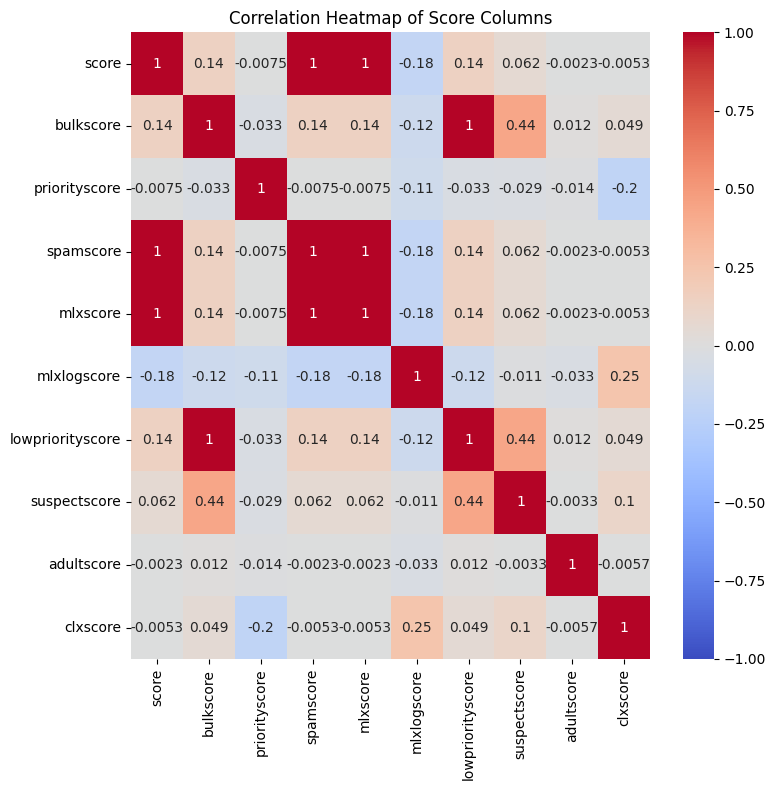

In [5]:
import seaborn as sns

score_columns = ['score', 'bulkscore', 'priorityscore', 'spamscore', 'mlxscore', 
                 'mlxlogscore', 'lowpriorityscore', 'suspectscore', 'adultscore', 'clxscore']

score_df = df[score_columns]
# Compute the correlation matrix
corr_matrix = score_df.corr()

# Create a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Score Columns')
plt.tight_layout()
plt.show()

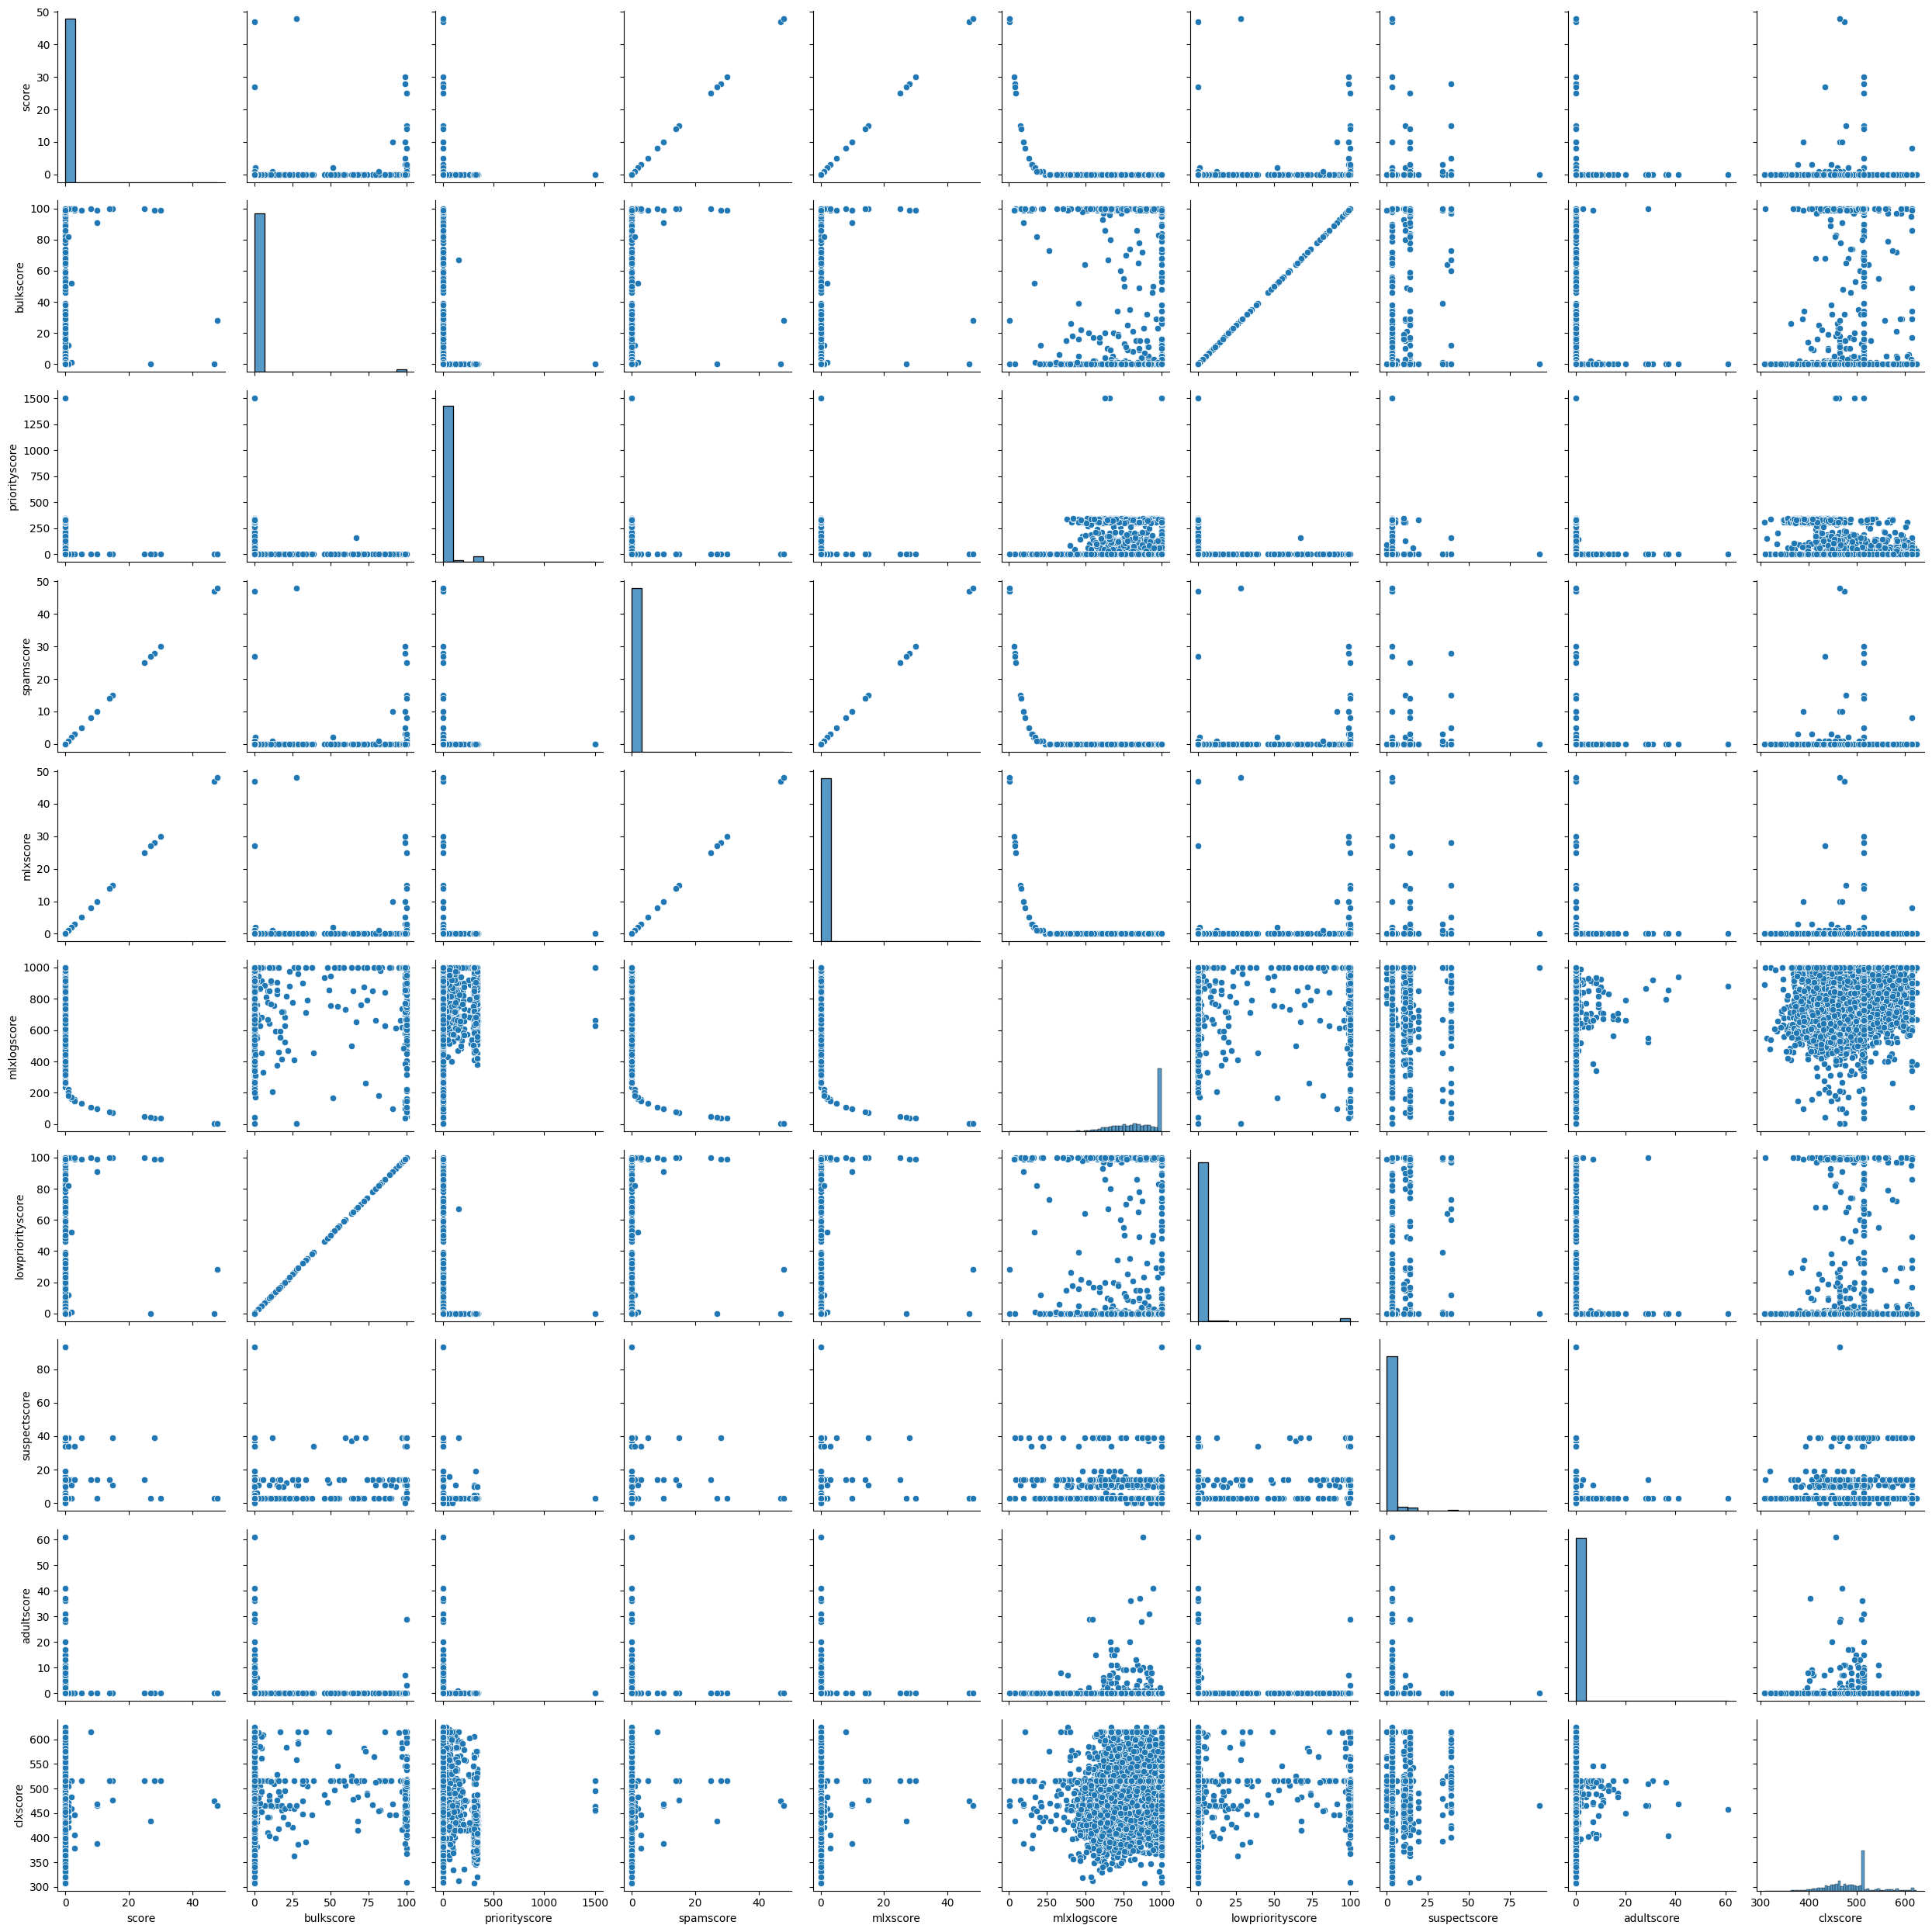

In [38]:
sns.pairplot(score_df)
plt.tight_layout()
plt.show()

## Old School, Still Cool

Natural Language Processing and computational linguistics were well-researched fields long before Large Language Models. Techniques from those research domains give us slightly more granular and explainable methods for exploring language data (and their often computationally easier). We'll use some of those to explore the email text as it relates to `mlxlogscore`.

Whether you're using classic NLP techniques or LLMs, the first step is going to be processing your big-ole-string-of-text into smaller units and associating those units with numbers (because computers are good at numbers): **tokenization** and **vectorization**. You can think of tokens as ~words, but there are some subtle distinctions. "Learning" may be tokenized into "Learn" and "ing". This helps ensure inputs related to "learn", "learning", "learned", "learner", etc stay related in the vector-space.

In the next cell, we define a [**t**erm-**f**requency * **i**nverse **d**ocument **f**requency (tfidf) vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). This looks at how frequently terms occur and punishes things that occur too often (because they don't carry information that help with our machine learning task). This scikit-learn function also has some handy arguments to reduce our feature space like removing stop words and words that don't occur more than a certain frequency. Note that we didn't tokenize first, so "learn" and "learning" will be vectorized separately.

In [6]:
# DO NOT CHANGE

vectorizer = TfidfVectorizer(stop_words="english", min_df=0.001, ngram_range=(1, 2))

# vec short for vector
vec = vectorizer.fit(df["content"])

word_doc_matrix = vec.transform(df["content"])
word_doc_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 737334 stored elements and shape (9898, 15080)>

In the vectorizer constructor, we can also pass an `ngram` definition. Words (and tokens) have meaning that may be useful to our machine learning task: `if the email contains "download", classify it as spam.` But sequences of words carry more meaning: `if the email has "don't download", classify it as ham.` `ngrams` are how we define those: bigram means sequences of two words, trigram for three, etc. While you can encode more meaning, the longer `ngram` sequences you include, the more your feature space explodes.

At the end of the code block, we'll have a word document matrix -- a _sparse_ representation about how often each ngram occurs in each email. Sparse means the same thing in math as it does it the lowly populated areas of the world, it's far-and-few between (mostly zero).

:::{tip}
You can reveal more details about variables and functions by clicking your mouse within the variable or function of a code cell and pressing Shift+Tab. This works once the variable or function is defined (it was imported or cell defining it was executed) and may not work while the kernel is busy in another cell, such as while training.
:::

:::{exercise}

Understanding exactly what made it through data processing steps is ultra important - you don't want to get half way through training a model before you realize you've missed something important. Always verify at every step. 

1. What english stop words did our vectorizer exclude? (Shift+Tab)
:::

In [ ]:
# your code here

:::{dropdown} Solution
If you (Shift+Tab), you will see that the stop words are "english" and defined by `_check_stop_list`. The useful part of open source software is we can see what that means. So looking at that function, [text.py on github](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/feature_extraction/text.py#L196C5-L196C21), we see it uses the variable. `ENGLISH_STOP_WORDS` and if we look at that definition we can see this list. [ENGLISH_STOP_WORDS on github](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/feature_extraction/_stop_words.py#L4)

Data visualization is useful for getting an intuition about the shape of the data (trends, linear separability, outliers, etc). However, we humans are only equipped to view data in 2 or 3 dimensions. Often, we use a dimensionality reduction technique like [principle component analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) or [stochastic neighbor embedding](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (`t-SNE`) to squeeze our data into two dimensions for visualization. 

Sadly, as you compress data, you lose some of the interpretability and variance - it's a lossy process. However, each of the methods here attempt to preserve as much of the "essence" of the original data as possible (PCA preserves variance, for example). These are _unsupervised_ techniques, which means they don't need labels (as opposed to supervised techniques), but coloring based on label can sometimes be helpful.

These will take a minute or two.

In [7]:
# DO NOT CHANGE

pca = PCA(
    n_components=2
)  # 2 components because we're going to create a 2 dimensional plot
pca_data = pca.fit_transform(word_doc_matrix.toarray())
print("[+] Done")

[+] Done


We'll visualize that in a minute.

PCA effectively transforms a dataset into a new dataset such that the greatest variance of the data lies along the first (principal) coordinate, the second greatest variance on the second coordinate, and so on. Variance is a measure of how spread out or dispersed the data points are in a dataset, and measures how far each data point is from the mean value.

We'll use a different technique this time, t-SNE

In [8]:
# DO NOT CHANGE

# Perform dimensionality reduction on the word-document matrix using t-SNE
embedded_content = TSNE(
    n_components=2, # again, 2 components for 2d plotting
    
    # Set the perplexity hyperparameter (affects the clustering behavior)
    perplexity=50, # this is the most significant hyperparameter. Feel free to adjust and see how it changes the shape
    
    # Set the learning rate to "auto" (adaptive learning rate)
    learning_rate="auto",
    
    # Use the cosine metric for distance calculations
    metric="cosine",
    
    # Initialize the embedding to be random
    init="random",
    
    # Use squared distances
    #square_distances=True,
    
    # parallelize all available cores
    n_jobs=-1,
    
).fit_transform(word_doc_matrix)

print("[+] Done")


C:\Users\Usuario\Anaconda3\envs\llama\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Usuario\Anaconda3\envs\llama\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[+] Done


We'll visualize that in the next cell.

t-SNE models similarities between data points in the high-dimensional space versus the low-dimensional space using conditional probabilities. Data points that are close together in the high-dimensional space have a high probability of being neighbors. t-SNE tries to match these neighborhood probabilities in the projected low-dimensional space. 

You can use these data structures to examine your data, but in this case, we're just using these two-dimensional projections to gain an intuition for our data distribution.

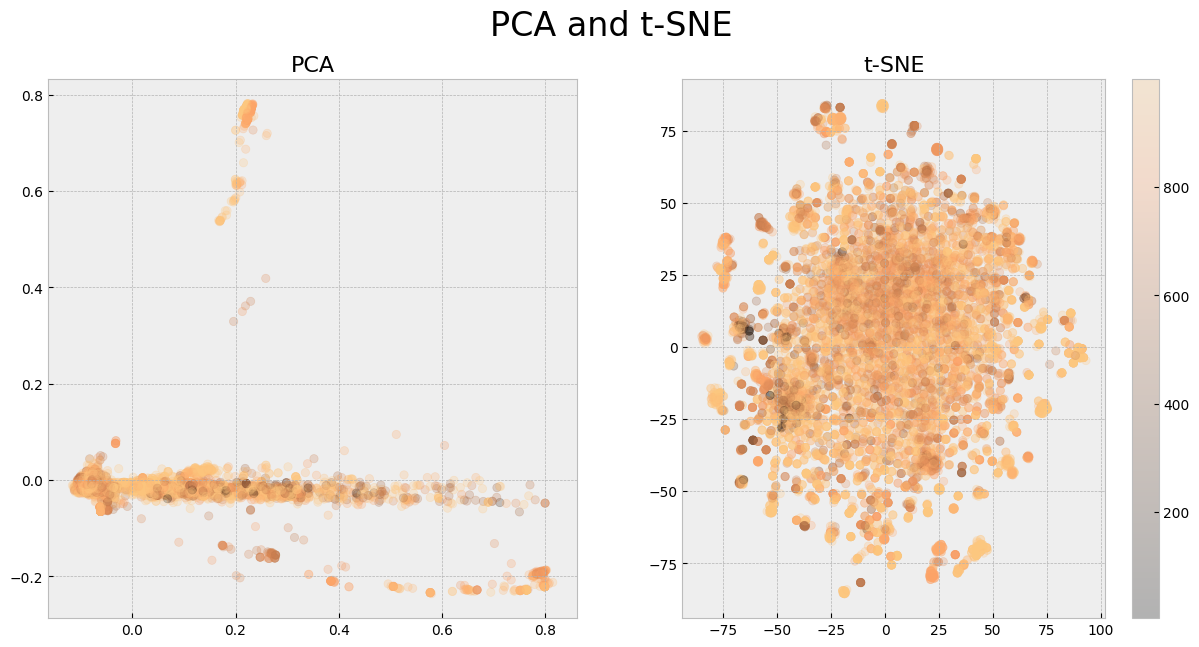

In [43]:
# DO NOT CHANGE

with plt.style.context("bmh"):
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    ax0 = ax[0].scatter(
        x=pca_data[:, 0],
        y=pca_data[:, 1],
        c=df["mlxlogscore"],
        cmap="copper",
        alpha=0.25,
    )
    ax[0].set_title("PCA", fontsize=16)
    ax1 = ax[1].scatter(
        x=embedded_content[:, 0],
        y=embedded_content[:, 1],
        c=df["mlxlogscore"],
        cmap="copper",
        alpha=0.25,
    )
    ax[1].set_title("t-SNE", fontsize=16)
    fig.colorbar(ax1)
    fig.suptitle("PCA and t-SNE", fontsize=24)
plt.show()

What are we looking at here? Each circle is an email, it's colored according to the `mlxlogscore` value. One thing to note is that these charts are unitless, it's our data embedded into a coordinate system we're visualizing in 2-Dimensions. Hopefully some of you are experiencing impulses to draw and draw a dividing line or circle interesting colors...

:::{exercise} 

View some of the other scores - change `c=df["mlxlogscore"]` to show a different metric from the data, like `mlxscore`, `clxscore`, etc.

```python
with plt.style.context("bmh"):
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    ax0 = ax[0].scatter(
        x=pca_data[:, 0],
        y=pca_data[:, 1],
        c=df["mlxlogscore"],
        cmap="copper",
        alpha=0.25,
    )
    ax[0].set_title("PCA", fontsize=16)
    ax1 = ax[1].scatter(
        x=embedded_content[:, 0],
        y=embedded_content[:, 1],
        c=df["mlxscore"],
        cmap="copper",
        alpha=0.25,
    )
    ax[1].set_title("t-SNE", fontsize=16)
    fig.colorbar(ax1)
    fig.suptitle("PCA and t-SNE", fontsize=24)
plt.show()
```
:::

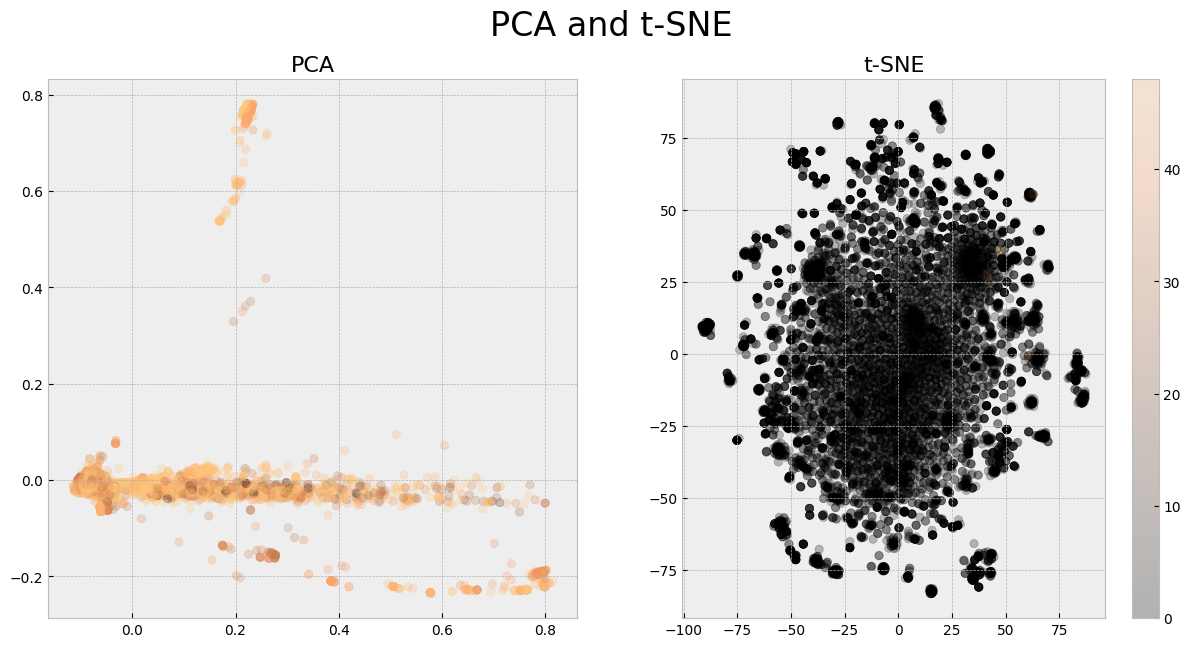

In [8]:
with plt.style.context("bmh"):
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    ax0 = ax[0].scatter(
        x=pca_data[:, 0],
        y=pca_data[:, 1],
        c=df["mlxlogscore"],
        cmap="copper",
        alpha=0.25,
    )
    ax[0].set_title("PCA", fontsize=16)
    ax1 = ax[1].scatter(
        x=embedded_content[:, 0],
        y=embedded_content[:, 1],
        c=df["mlxscore"],
        cmap="copper",
        alpha=0.25,
    )
    ax[1].set_title("t-SNE", fontsize=16)
    fig.colorbar(ax1)
    fig.suptitle("PCA and t-SNE", fontsize=24)
plt.show()

What do we want you to take from that? Really, just the technique. Visualize your data, get an intuition for how it's distributed, how many clusters there are, etc. You can find some really interesting insights.

Let's continue our exploration and review those preprocessing steps and move into some correlations! Here's an email and it's associated ngrams.

In [9]:
# DO NOT CHANGE

email = 13

print(f"Raw email:\n{df.iloc[email]['content']}")
print(f"Processed email:\n{vec.build_analyzer()(df.iloc[email]['content'])}")

Raw email:
In order to ensure that our contact list is complete, we are asking the head of every Enron office/facility to provide 24-hour contact information to john.brindle@enron.com.  Thank you.

Processed email:
['order', 'ensure', 'contact', 'list', 'complete', 'asking', 'head', 'enron', 'office', 'facility', 'provide', '24', 'hour', 'contact', 'information', 'john', 'brindle', 'enron', 'com', 'thank', 'order ensure', 'ensure contact', 'contact list', 'list complete', 'complete asking', 'asking head', 'head enron', 'enron office', 'office facility', 'facility provide', 'provide 24', '24 hour', 'hour contact', 'contact information', 'information john', 'john brindle', 'brindle enron', 'enron com', 'com thank']


In [11]:
?vec.build_analyzer

Signature: vec.build_analyzer()
Docstring:
Return a callable to process input data.

The callable handles preprocessing, tokenization, and n-grams generation.

Returns
-------
analyzer: callable
    A function to handle preprocessing, tokenization
    and n-grams generation.
File:      c:\users\usuario\anaconda3\envs\llama\lib\site-packages\sklearn\feature_extraction\text.py
Type:      method

In [14]:
# DO NOT CHANGE

# we create a new dataframe from our word document matrix and the mlxlogscore label

df1 = pd.DataFrame(word_doc_matrix.toarray(), columns=vec.get_feature_names_out())
df1["mlxlogscore"] = df["mlxlogscore"]
features = [x for x in df1.columns.tolist() if x not in ["mlxlogscore"]]
corrs = df1[features].corrwith(df1["mlxlogscore"], numeric_only=True)
corrs = corrs.sort_values()
print("[+] Done")

[+] Done


We used `corrwith`, a built-in pandas function to measure the pairwise correlation of the ngrams we created to our target variable `mlxlogscore`. It could be that there a already specific words we should avoid before we decide to build _any_ models. For example, here are the top 5 most spammy and hammy ngrams:

In [11]:
# DO NOT CHANGE

for i in range(5):
    print(f"Spammy: {corrs.index[i] : <20}\tHammy: {corrs.index[-(i+1)] : >10}")

Spammy: attached            	Hammy:      enron
Spammy: click unsubscribe   	Hammy:  enron com
Spammy: image               	Hammy:     create
Spammy: gmt 06              	Hammy:       date
Spammy: central time        	Hammy:     report


C:\Users\Usuario\AppData\Local\Temp\ipykernel_59796\472437032.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_ylim((corrs[0] - 0.05, corrs[-1] + 0.05))


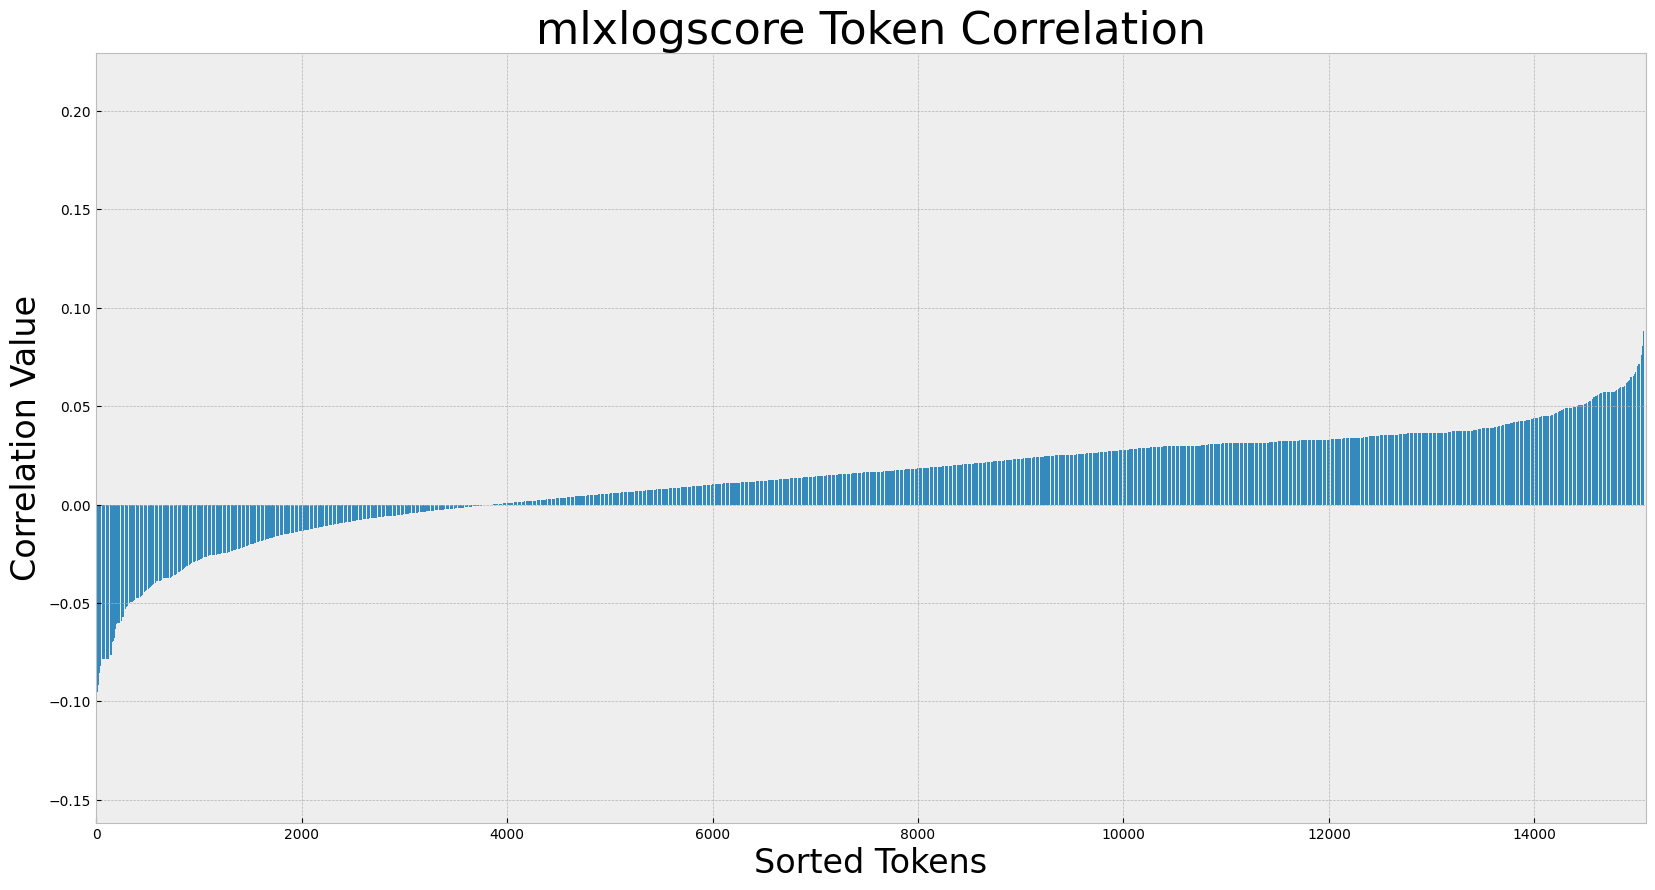

In [12]:
# DO NOT CHANGE

with plt.style.context("bmh"):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.bar(x=[i for i in range(len(corrs))], height=corrs)
    ax.set_xlim((-5, len(corrs) + 5))
    ax.set_ylim((corrs[0] - 0.05, corrs[-1] + 0.05))
    ax.set_title("mlxlogscore Token Correlation", fontdict={"fontsize": 32})
    ax.set_xlabel("Sorted Tokens", fontdict={"fontsize": 24})
    ax.set_ylabel("Correlation Value", fontdict={"fontsize": 24})
plt.show()

We can see that there are far more tokens correlated with an increase in `mlxlogscore` than against it. So what do we do with this information? That all depends on our operational objectives.

- This dataset (Enron emails) along with the scores is enough to train a copy-cat. Operational considerations might be _how few_ of the emails you need to use (and how to select them).
- At the most basic level, we can reference this list to determine which tokens we should avoid and which words we should repeatedly use to move our score in the desired direction. Think of this as a manual evasion.
- We did this analysis in bulk after retrieving all of this information. Instead, we could have built the corpus of tokens and correlations with `mlxlogscore` _during the attack_, potentially providing some early stopping opportunities or chances to craft custom payloads to expand our search space.

Think back to these plots:

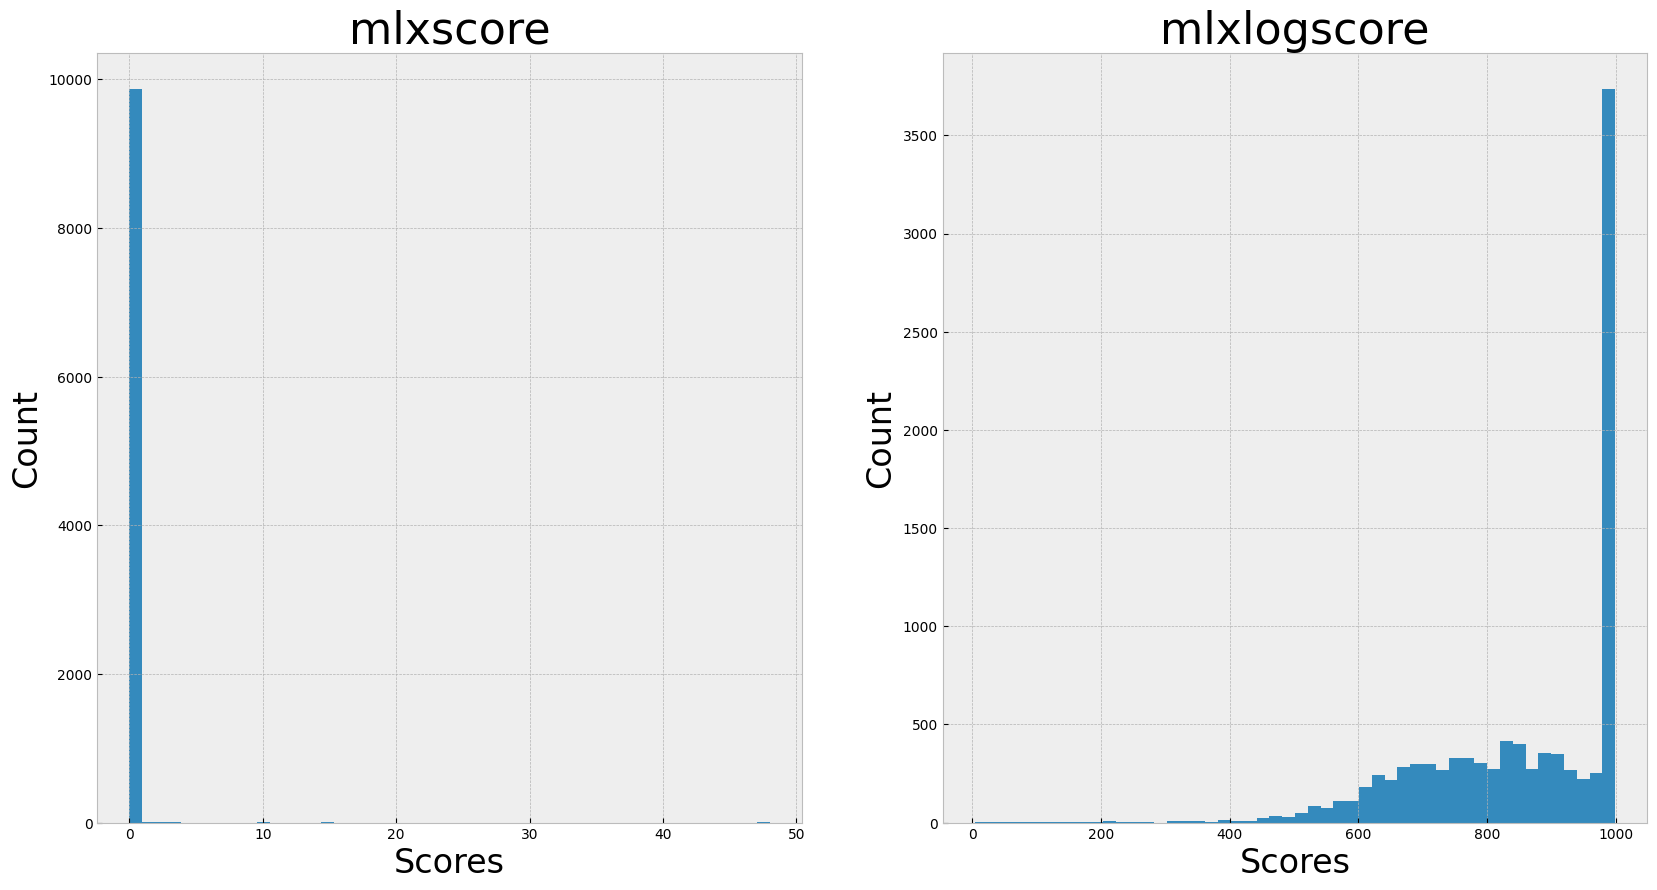

In [13]:
# DO NOT CHANGE

with plt.style.context("bmh"):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].hist(x=df["mlxscore"], bins=50)
    ax[0].set_title("mlxscore", fontdict={"fontsize": 32})
    ax[0].set_xlabel("Scores", fontdict={"fontsize": 24})
    ax[0].set_ylabel("Count", fontdict={"fontsize": 24})
    ax[1].hist(x=df["mlxlogscore"], bins=50)
    ax[1].set_title("mlxlogscore", fontdict={"fontsize": 32})
    ax[1].set_xlabel("Scores", fontdict={"fontsize": 24})
    ax[1].set_ylabel("Count", fontdict={"fontsize": 24})
plt.show()

**We generated this.** The imbalance of both of these scores isn't necessarily indicative of the quality of the model underlying the API. It's a combination of the model and the data we used to generate the labels and get these scores. It's possible that more targeted data creation and queries would have returned more balanced datasets that could tell us more about the model behavior in currently unseen regions of space (email space, not outer-space). Now with generative techniques, there are probably many more things you could do to generate an e-mail for this dataset...

:::{exercise}

1. Pick a word and find out how correlated it is (or isn't) to `mlxlogscore`.
2. What are some weaknesses to this approach? Is there any way we can tell the potential impact of a word not in the dataset?

In [17]:
# your code here
corrs['test']

0.02387059834258008

:::{dropdown} Solution
`corrs['test']` will print the correlation of the word 'test' with mlxlogscore.
This approach is only as strong as the data. So if the data is lacking the aproach will be as well.
For example, `corrs['hola']` will cause an error, because the value does not exist in the dataset so there is no way to form a corelation.

## Create a Training Pipeline

Next, we're going to take a small detour, or more accurately, a shortcut. We've mentioned the importance of experimentation a few times, which means we need a lot of models. The way we have been loading models is useful while you were a module younger, with less gray hairs, but now things are getting serious. Our solution for being super serious is to use the `transformers` library from HuggingFace. They have an expansive selection of models and datasets. They make it so easy to just stand up and model and go - and they give you starter code for it. You just copy and paste, fiddle with some formatting, and you're pretty much done. 

It handles the preprocessing, everything. The best part, is that if you're new, you can use models knowing sensible defaults are in place. Here we show you using `transformers` with their `AutoClass` primitive. You provide the name or path a model, and it loads it for you. Supporting classes like tokenizers follow the same pattern!  (Don't worry about the red text, we're going to fine-tune this model on our use case)

In [4]:
# DO NOT CHANGE

# this is the model we want to train
model_name = "bert-base-uncased" 

# add the preprocessor
tokenizer = AutoTokenizer.from_pretrained(model_name)

C:\Users\Usuario\Anaconda3\envs\llama\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Though, it's not "free" to use. The abstractions are useful if your data is correctly formatted. You have to do this process anyway, so it's nice you can plug it into a framework that gives you access to all kinds of extra functionality _if_ you take the time to do it properly. Which we recommend in this case because it's worth it, let's do that. 

In [5]:
# DO NOT CHANGE

max_len = 512

encodings = tokenizer(df['content'].tolist(), truncation=True, padding="max_length", max_length=max_len)

# Extract input ids, masks and convert to tensors
input_ids = torch.tensor(encodings.input_ids)
attention_masks = torch.tensor(encodings.attention_mask)

We'll get into the details of this code in the LLM lab - but here's a brief rundown - 

- `tokenizer`: is a _pretrained_ tokenizer that will convert text to numeric IDs. From which we get `encodings`
- `input_ids` and `attention_masks` extract just the numeric ids and masks from the `encodings`

In short -  `input_ids` are the numeric token ids for each word in the input sequences. The tokenizer converts the raw text into ids that correspond to tokens in the model's vocabulary (all the words it knows). This represents the main input fed into the model. 

`attention_masks` is a new concept. This is a tensor containing `1`s and `0`s indicating which tokens are real words vs padding. Specifically, `1` indicates a real token, and `0` indicates padding. This helps the self-attention layers in Transformers focus only on real tokens and ignore padding. Remember that model need square matrices, but text is naturally variable length, padding ensures these text representations are square so we can perform that sweet sweet matrix multiplication. 

Next, we need to gather the labels, but here's the issue, our labels are between `0` and `999`. Which models _can_ use (because math), but for reasons we don't have time to explain in detail here (it's in your book), should be something else. Like maybe `0` or `1`... 

:::{exercise} 

We just did some visualization to infer a decision boundary - let's make use of it. 

1. Create labels using a threshold you discovered above such any value above your threshold is `1` and any value below is `0`. 
2. What about for other scores like `clxscore`?

:::

In [6]:
# provided code
labels = torch.tensor(df['mlxlogscore'].values).float()

# your code here
threshold = 100

Then we create the `Dataset` according to the HuggingFace requirements. Feel free to poke around at all the various things you get as a result of using this abstraction. `hf_dataset.data`.

In [7]:
# DO NOT CHANGE

# Relabel based on threshold 
labels = (labels >= threshold).long()

# Create DatasetDict
hf_dataset = Dataset.from_dict(
    {
        'input_ids': input_ids.tolist(),
        'attention_masks': attention_masks.tolist(),
        'labels': labels.tolist()
    }
)

In [8]:
train_test = hf_dataset.train_test_split(test_size=0.2)
train_dataset = train_test['train']
test_dataset = train_test['test']

Again, we just use the `AutoClass` primitive to load a model. One thing to note is the `num_labels` argument - we have a `0` or `1` which means we have two labels. If we had squashed the `0-999` between `0` or `1`, we'd only have `1` label. 

In [9]:
# DO NOT CHANGE

# we use AutoModel + the task  we want
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

# Don't worry about the warnings

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


And what used to be a behemoth piece of code, now looks manageable. And because you stared at all that code in the previous labs, you probably have a good idea about what each of these abstractions does for you. Now we can just go... this compact code look much nicer than all the model code we looked at earlier - you can of course pick and choose the abstractions you want to use depending on what code you have, or control you want over the process. 

Next, we'll talk about the `Trainer` abstraction. **Go ahead and Shift+Tab on TrainingArguments** and just scroll through that massive list of arguments. While it can be overwhelming, you should note that most values are `False` or `None`. As you start to explore the bounds of this space, deal with smaller GPUs, weird requirements, etc. The relevant arguments will make themselves apparent. 

Then, at the bottom we call `trainer.train()` and let math do its thing. 

In [ ]:
# DO NOT CHANGE

from transformers import TrainingArguments, Trainer

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
)

# Create a Trainer
trainer = Trainer(
    model=model,                     # the instantiated 🤗 Transformers model to be trained
    args=training_args,              # training arguments, defined above
    train_dataset=train_dataset,     # training dataset
    eval_dataset=test_dataset        # eval dataset
)

# Train the model
trainer.train()


# This is going to take ~10 minutes

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step,Training Loss
100,0.141900
200,0.010100
300,0.000700
400,0.005100
500,0.005600
600,0.000100


Then we evaluate (as is tradition). The above isn't that informative... ML code is messy, there's a lot going on and the abstractions are useful, but they _are_ abstractions. Get in the habit of reading through documentation and code, your ML life will be easier if you verify your assumptions the first time.

In [ ]:
# DO NOT CHANGE

# Evaluate on the validation set  
eval_results = trainer.evaluate() 

print(f"Validation results: {eval_results}")

The model looks not amazing - could use some more time in the oven. However, even if it were perfect, remember that solving a problem is a function of user acceptance. For example, I bet all the ChatGPT's of the world do well on any number of benchmarks, but users still find things to complain about. 

In [ ]:
# DO NOT CHANGE

model.eval() # we did just eval. But just in case...you can't be too careful.

example = tokenizer("Please click on this link", return_tensors="pt") # insert your own string to test

with torch.no_grad():
    outputs = model(**example.to(device))

predictions = outputs.logits.argmax(-1)
print(f"Prediction (0/1):\n---------------\n{predictions.item()}\n")

# Extracting Classifiers: AMSI 
Next, we're going to look an already discretely labeled problem, and create a copy-cat of AMSI. At a high level AMSI is a standard interface to allow any security product to label software as benign or malware.

> The Windows Antimalware Scan Interface (AMSI) is a versatile interface standard that allows your applications and services to integrate with any antimalware product that's present on a machine. AMSI provides enhanced malware protection for your end-users and their data, applications, and workloads. AMSI is agnostic of antimalware vendor; it's designed to allow for the most common malware scanning and protection techniques provided by today's antimalware products that can be integrated into applications. It supports a calling structure allowing for file and memory or stream scanning, content source URL/IP reputation checks, and other techniques.

The implementation is a DLL (amsi.dll) that gets called into PowerShell, UAC dialogs, JScript, VBScript, and .NET 4.8 whenever they are executed (more specifically, when particular functions are executed). After `amsi.dll` has been loaded, the `AmsiScanBuffer()` and `AmsiScanString()` methods are responsible for collecting the relevant content and passing it back through RPC to an AMSI provider. An AMSI provider represents a security product that has the opportunity to inspect content given to it by AMSI. So it doesn't have to be Windows Defender, for example.  

The provider is free to analyze the content in any way they like (machine learning), but should return a value between `0` and `32767` for benign content. The larger the number, the "riskier" the content. A result that is equal to or larger than `32768` is considered malware, in this case AMSI will return [`AmsiResultIsMalware`](https://docs.microsoft.com/en-us/windows/win32/api/amsi/ne-amsi-amsi_result) and execution will be stopped. Currently Defender returns either a `0` or a `32768`, but a range of scores is possible for future updates.

It should be mentioned that Microsoft does not consider AMSI to be a security boundary, this makes sense as it is simply an interface to a provider, so "bypassing AMSI" is perhaps a strange term. However, there are a number of [public AMSI "bypasses"](https://github.com/S3cur3Th1sSh1t/Amsi-Bypass-Powershell) floating around on the Internet. Most techniques rely on patching memory such that AMSI has no or incomplete content to send for scanning. Memory patching is effective because amsi.dll is loaded into the same process space as a piece of malware, and as there are no privilege boundaries intra-process, a piece of malware is free to make memory modifications.

## The Dataset
We have already collected roughly `150,000` labels and provided them to you in this course. We use a large repository of PowerShell scripts that were made public from Lee Holmes and Daniel Bohanans talk, ["Revoke-Obfuscation: PowerShell Obfuscation Detection Using Science"](https://www.blackhat.com/docs/us-17/thursday/us-17-Bohannon-Revoke-Obfuscation-PowerShell-Obfuscation-Detection-And%20Evasion-Using-Science-wp.pdf) from Blackhat 2017. The best part about this corpus is that it has both malicious and non-malicious files in it. But as attackers, we often don't have access to large datasets and collecting large amounts of data can be operationally expensive.  so when you find a [large repository of something interesting](https://figshare.com/articles/Enron_Spreadsheets_and_Emails/1221767) keep it! More generally, as machine learning attacks become more prevalent, expect free data to be a thing of the past, you should instead start to curate your own datasets internally. 

To get a labelled dataset, we use a sample AMSI project provided by Microsfoft on their github. 

```bash
.\AmsiStream.exe "Invoke-WmiBackdoor.ps1"
    Creating stream object with file name: Invoke-WmiBackdoor.ps1
    Calling antimalware->Scan() ...
    GetAttribute() called with: attribute = 0, bufferSize = 1
    GetAttribute() called with: attribute = 0, bufferSize = 68
    GetAttribute() called with: attribute = 1, bufferSize = 1
    GetAttribute() called with: attribute = 1, bufferSize = 46
    GetAttribute() called with: attribute = 2, bufferSize = 8
    GetAttribute() called with: attribute = 3, bufferSize = 8
    Read() called with: position = 0, size = 11250
    GetAttribute() called with: attribute = 4, bufferSize = 8
    GetAttribute() called with: attribute = 6, bufferSize = 8
    GetAttribute() called with: attribute = 8, bufferSize = 8
    Scan result is 1. IsMalware: 0
    Provider display name: Microsoft Defender Antivirus
    Leaving with hr = 0x0
```

Some important items to note, firstly, the `Provider display name`. If there is no provider or Windows Defender has been turned off, the program will fail which will cause an error to be displayed on the following line `Leaving with hr = <ERROR>`. The Second item of note is the `Scan result` field. This field represents the label Windows Defender gave the script and is ultimately what we're interested in collecting. The output of a positive result is only noticed in the `Scan result` field, 

```bash
> .\AmsiStream.exe "PowerView.ps1"

    Creating stream object with file name: PowerView.ps1
    Calling antimalware->Scan() ...
    ...
    Scan result is 32768. IsMalware: 1
    Provider display name: Microsoft Defender Antivirus
    Leaving with hr = 0x0

```

## Creating Your Model
Okay - now it's time to apply what you've learned with a dataset that is large and messy... aka realistic! While we're focused on extracting a classifier, you'll have to think much more creatively about your data preparation. How can you clean and transform this data to give your model the best shot at being a faithful (or at least useful) extraction of Defender? You should be able to lean _heavily_ on your experience to do this, the challenge will be trying to fit what you know into these new-fangled ML tools. 

In [2]:
# DO NOT CHANGE

df = pd.read_csv("data/amsi/defender_data.csv", header=0, skiprows=lambda x: x % 10 != 0)
# It's a big dataset, we'll start out by just loading a sample.
# Feel free to play with the ratio, but know that pandas loads the entire structure into memory.

df = df.dropna().reset_index(drop=True)
# remove bad vals

df.head()

,name,hash,label,content
0,startChocolatey.ps1,764b29980e305e696aad2f7c9b82f6c0,Scan result is 1. IsMalware: 0,w6/Cu8K/PCMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIy...
1,common.ps1,f25c874cc9cee26ad8fe9f8aa3aa5da7,Scan result is 1. IsMalware: 0,ZnVuY3Rpb24gQWRkT3JVcGRhdGUtUmVmZXJlbmNlKCRzY3...
2,EntityFramework.psm1,27653f77dc9b0ca49f0f5603bb9eb515,Scan result is 1. IsMalware: 0,IyBDb3B5cmlnaHQgKGMpIE1pY3Jvc29mdCBDb3Jwb3JhdG...
3,uninstall.ps1,35bbf24389cc8bd2d8dcea9766ffd1e9,Scan result is 1. IsMalware: 0,cGFyYW0oJGluc3RhbGxQYXRoLCAkdG9vbHNQYXRoLCAkcG...
4,child-powershell.ps1,d83bf1333ff4979fbb4201261d7ce267,Scan result is 1. IsMalware: 0,cGFyYW0oCglbc3RyaW5nXSAkRGFkCikKCldyaXRlLU91dH...


Each file has all the relevant information attached to the sample - the original filename, MD5 hash, label from Windows Defender, and the base64 encoded script content.

In [3]:
# DO NOT CHANGE

df["content"] = df["content"].apply(lambda x: base64.b64decode(x).decode())
# The scripts were b64 encoded, let's recover the text

In [4]:
# DO NOT CHANGE

df["label"] = df["label"].apply(lambda x: int(x.split("IsMalware: ")[-1]))
# The labels were descriptive, but converting them to binary will save us work later

In [5]:
# DO NOT CHANGE

df.head()
# Let's see the first couple now that we've cleaned up a bit

,name,hash,label,content
0,startChocolatey.ps1,764b29980e305e696aad2f7c9b82f6c0,0,ï»¿<##########################################...
1,common.ps1,f25c874cc9cee26ad8fe9f8aa3aa5da7,0,function AddOrUpdate-Reference($scriptsFolderP...
2,EntityFramework.psm1,27653f77dc9b0ca49f0f5603bb9eb515,0,# Copyright (c) Microsoft Corporation. All ri...
3,uninstall.ps1,35bbf24389cc8bd2d8dcea9766ffd1e9,0,"param($installPath, $toolsPath, $package, $pro..."
4,child-powershell.ps1,d83bf1333ff4979fbb4201261d7ce267,0,"param(\n\t[string] $Dad\n)\n\nWrite-Output ""He..."


:::{exercise}
In your sample, how many examples are malware?
:::

In [7]:
# Your code here
df.label.value_counts()

label
0    38075
1      105
Name: count, dtype: int64

:::{dropdown} Solution
The following code will print the number of malware samples because any that are malware are 1 and any that aren't are 0, so adding them all up gives the number of malware samples.
```python
print("number of samples labelled as malware",sum(df['label']))

Let's do some manually inspection. I want to see one of these scripts.

In [8]:
# DO NOT CHANGE

print(df[df["label"] == 1].iloc[0]["content"])


function Invoke-CredentialsPhish
{
<#
.SYNOPSIS
Nishang script which opens a user credential prompt.

.DESCRIPTION
This payload opens a prompt which asks for user credentials and does not go away till valid local or domain credentials are entered in the prompt.

.EXAMPLE
PS > Invoke-CredentialsPhish

.LINK
http://labofapenetrationtester.blogspot.com/
https://github.com/samratashok/nishang
#>

[CmdletBinding()]
Param ()

    $ErrorActionPreference="SilentlyContinue"
    Add-Type -assemblyname system.DirectoryServices.accountmanagement 
    $DS = New-Object System.DirectoryServices.AccountManagement.PrincipalContext([System.DirectoryServices.AccountManagement.ContextType]::Machine)
    $domainDN = "LDAP://" + ([ADSI]"").distinguishedName
    while($true)
    {
        $credential = $host.ui.PromptForCredential("Credentials are required to perform this operation", "Please enter your user name and password.", "", "")
        if($credential)
        {
            $creds = $credential.GetNe

:::{exercise}
We could pass that straight into a vectorizer and see what tokens are correlated with being classified as malware, or maybe we could do some more preprocessing. Before you train a model, you usually want to explore the data (exploratory data analysis: EDA). Try something.

Write a function to do some EDA. Potentially use what you discover to preprocess or transform your data.
:::

:::{exercise}
**Challenge**
Train a proxy model. Remember "all models are wrong, some models are useful."

Here's a simple (and very wrong) example. Do better.
:::

In [9]:
# DO NOT CHANGE

creds = df["content"].str.contains("credentials").astype(int)
creds = np.array(creds).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(creds, df["label"], test_size=0.2)
lr = LogisticRegression().fit(X_train, y_train)
print(lr.score(X_test, y_test))

0.9975117862755369


:::{dropdown} Solution
Experiment with different options, the ConfusionMatrix in the next block will show how good of a choice that was.

Are we great data scientists?!

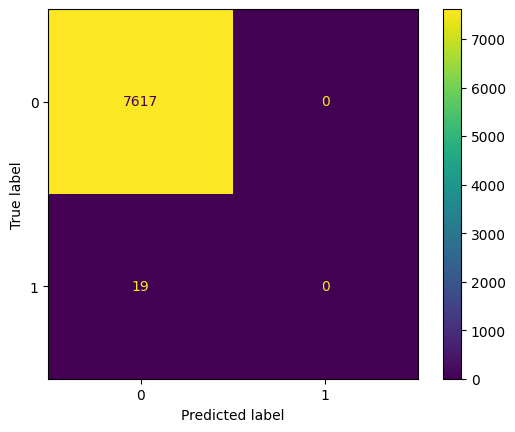

In [11]:
disp =  ConfusionMatrixDisplay(confusion_matrix(y_test, lr.predict(X_test)))
disp.plot()
plt.show()

Maybe not. We get that great accuracy score by never predicting anything as malware. That's how imbalanced datasets will get you! Try something new.

In [14]:
# Your code here
y_test.value_counts()

label
0    7617
1      19
Name: count, dtype: int64

# Conclusion

With this we wrap up Extraction. At this point you should realize that you are part Data Scientist, part ML Engineer, and part Red Teamer. While you can be successful with simply throwing data at a model, it's probably better to be a little more thoughtful about your approach from the start. You should also consider collecting and curating datasets as part of offensive operations - where those are against a model or a network. You should version and keep metadata about your data. 

But we hope you can see how this relatively simple and opsec friendly process can be extremely effective. Consider how this approach differs from the Evasion attacks we covered in the first lab. Additionally, you can even use generative techniques to create and curate datasets with the distributions you want! 

## What You Learned
1. Execute the Proof-Pudding attack (CVE-2019-20634).
2. Extract a model useful for cybersecurity.

**Move on to the [Model Assessments Module](../4_assessments/1_assessments.ipynb).**

![DLI Logo](../assets/DLI_Header.png)